* Import importent stuff. 
* pay attention: **%matplotlib notebook** isn't working in **Jupyter lab**, only in **Jupyter notebook**
* It allow Interactive matplotlib GUI, therefore **Jupyter notebook** is very recommended

In [1]:
import cv2
import os
from functions import plot_samples,calc_depth_grads, plot_samples_grads, calc_pixelwise_diffs, calc_diffs, plot_samples_diffs
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
%matplotlib notebook

* define working directories (excluded from the git - see .gitignore)

In [2]:
depth_dir = 'depth'
rgb_dir   = 'rgb'
pwd = os.getcwd()
depth_dir = os.path.join(pwd,depth_dir)
rgb_dir   = os.path.join(pwd,rgb_dir)

* pick samles randomly for testing

In [3]:
depth_fnames = os.listdir(depth_dir)
depth_fnames.sort()

depth_abs_fnames = [os.path.join(depth_dir,f) for f in depth_fnames]
rgb_abs_fnames   = [os.path.join(rgb_dir,f) for f in depth_fnames]

samples_idx   = np.random.choice(len(depth_abs_fnames), 4)
depth_samples = [depth_fnames[i] for i in samples_idx]
depth_samples

['671.png', '288.png', '779.png', '1098.png']

* Show the samples (rgb & rgbd)

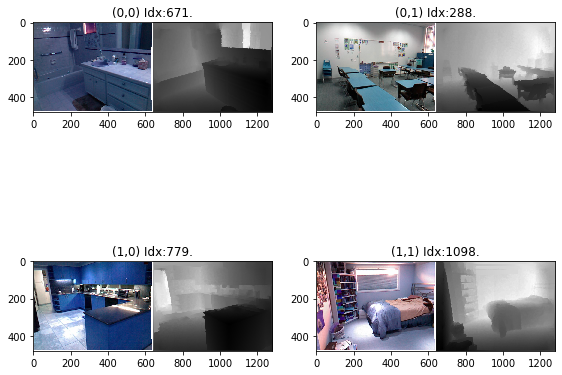

In [4]:
plot_samples(samples_fnames=depth_samples, depth_dir=depth_dir,rgb_dir=rgb_dir,figsize=(8,8))

* First, let's define a simple test image to check out approaches.
    * first approach: Gradient of the depth map using Soble & Scharr filters
    * second approach: pixel-wise difference calculation

* Our test image include 4 typical cases for depth direction estimation:
    * Closer object on farther background (upper left). for example: an obstacle
    * Farther object surrounded by closer area (bottom right). for example: a window / a door
    * A bold frame (upper right)
    * A sinked frame (bottom left)

* Pay attention that because numpy coordination system (origin at the upper-right corner), the quiver is fliped. the arrows orientation is correct.

In [5]:
test_img = np.ones((30,30))

test_img[3:8,3:8] = 0     # closer than background object (an obstacle for instance)
test_img[20:26,20:26] = 2 # farther than it surroundings object (a door, a window) 

test_img[3:11, 18:26] = 0 # a closer frame
test_img[6:8, 21:23]  = 1

test_img[18:26,3:11] = 2 # a farther frame
test_img[20:24,5:9]  = 1


grad_x = cv2.Sobel(test_img,cv2.CV_64F,1,0,ksize=-1)
grad_y = cv2.Sobel(test_img,cv2.CV_64F,0,1,ksize=-1)

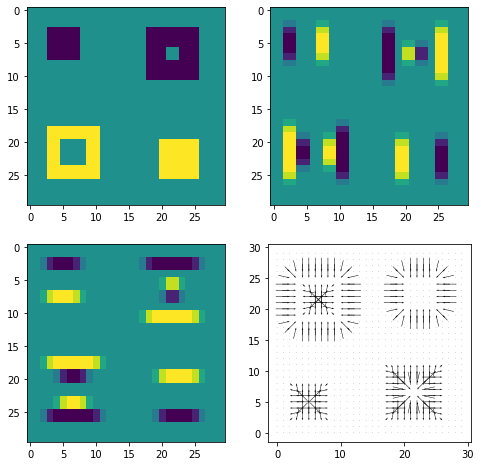

In [6]:
X,Y = np.meshgrid(np.arange(test_img.shape[1]), np.arange(test_img.shape[0]))
U = grad_x
V = grad_y
fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[1,1].quiver(X, Y, U, V, pivot='tip', units='xy')
ax[0,0].imshow(test_img)
ax[0,1].imshow(grad_x)
ax[1,0].imshow(grad_y)
plt.show()

Now let's try it on a real batch of samples from the depth images data-set

In [7]:
grads = calc_depth_grads(depth_samples,depth_dir, ksize=5, gradient_degree=1)

0) 671.png ... done.
1) 288.png ... done.
2) 779.png ... done.
3) 1098.png ... done.


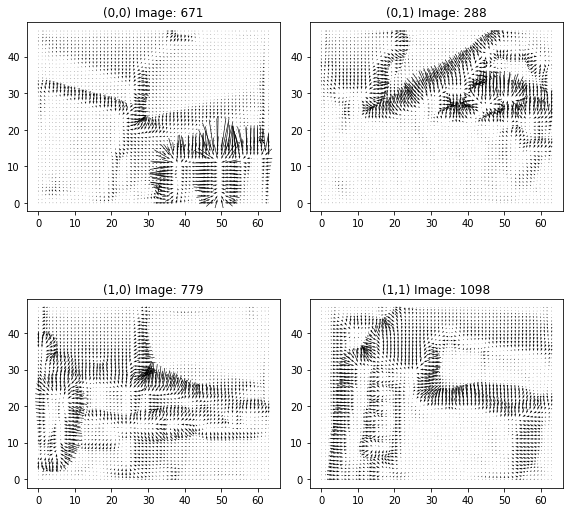

In [8]:
plot_samples_grads(grads)

You can see that the result are not bad at all. of-course there are some artifacts (can be handled maybe by changing the kernel size and/or averaging groups of arrows)

* Now let's try the version of pixel-wise difference
* note that from complexity prespective it's much worst than the gradient approach 

In [9]:
diff_x,diff_y = calc_pixelwise_diffs(test_img)

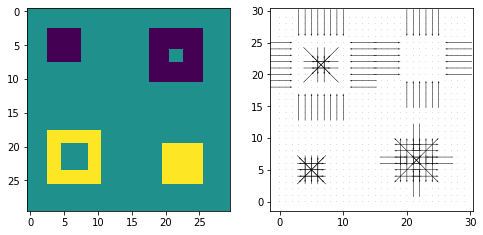

In [10]:
X,Y = np.meshgrid(np.arange(test_img.shape[1]), np.arange(test_img.shape[0]))
U = diff_x
V = diff_y
fig, ax = plt.subplots(1,2,figsize=(8,8), subplot_kw={'aspect': 1})
ax[1].quiver(X, Y, U, V, pivot='tip',units='xy')
ax[0].imshow(test_img)
plt.show()

It works not bad, but definatly worst that the gradient approach, especcialy in corners

In [11]:
diffs = calc_diffs(depth_samples,depth_dir)

/home/manor/cs236781-DeepLearning/project/functions.py:119: RuntimeWarning: overflow encountered in ubyte_scalars
  diff_x[i, j] += pix - img[i, j - 1]
/home/manor/cs236781-DeepLearning/project/functions.py:104: RuntimeWarning: overflow encountered in ubyte_scalars
  diff_y[i, j] += pix - img[i - 1, j]
/home/manor/cs236781-DeepLearning/project/functions.py:109: RuntimeWarning: overflow encountered in ubyte_scalars
  diff_y[i, j] += img[i + 1, j] - pix


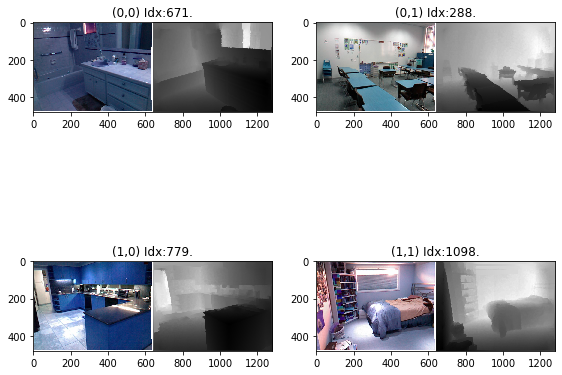

In [12]:
plot_samples(samples_fnames=depth_samples, depth_dir=depth_dir,rgb_dir=rgb_dir,figsize=(8,8))

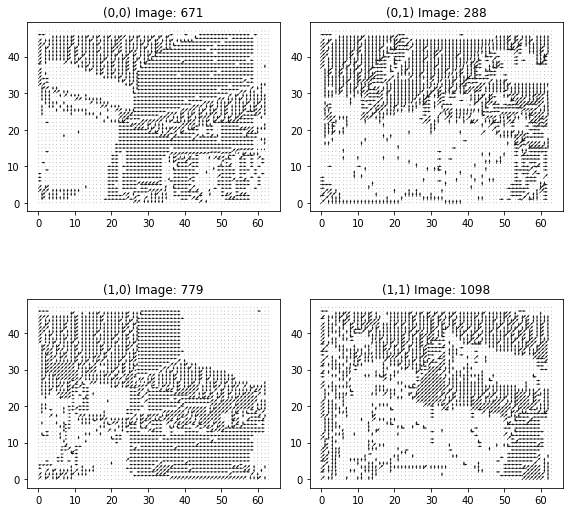

In [13]:
plot_samples_diffs(diffs)

Well, it definatly not works on large scale...

## To conclude, currently our approach of choose need to be the gradient approach.